In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import sys
import os
import glob
import pickle

# Add needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random


#### QUESTIONS ####
'''
- Use ResNet50, doesn't seem like there would be any benefit to 101 or 152

- Files are large, storing paths in arrays, to open when training, is this
  best approach or should I try to modify the images to make them smaller?
  
- Speaking of modifying, it seems ResNet50 takes 224x224 as it's input
  dimensions.  It seems to allow me to set the input size, not sure what
  this is doing yet?  

- Should I resize images or try to add custom layers at front of network
  to output as 224x224x3?

- My understanding is I use the pre-trained model as the base model and 
  then customize the output by removing the last few layers of ResNet50
  and adding my own layers and an Sigmoid or something as the output?
  
- Should I keep this simple or play around with custom builds on top of 
  ResNet?
  
- What were the other pretrained models you suggested besides ResNet?

--- Pretrained models: MobileNet (smaller model, can fit on Mobile Phone)
--- Fully connected layers or just a softmax layer
--- Prepend layers at beginning, shrink through a couple of fully connected layers

References:
- https://www.kaggle.com/code/donkeys/keras-binary-cats-dogs-resnet-98
- https://discuss.tensorflow.org/t/input-dimension-of-resnet50/1594
- https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
'''

"\n- Use ResNet50, doesn't seem like there would be any benefit to 101 or 152\n\n- Files are large, storing paths in arrays, to open when training, is this\n  best approach or should I try to modify the images to make them smaller?\n  \n- Speaking of modifying, it seems ResNet50 takes 224x224 as it's input\n  dimensions.  It seems to allow me to set the input size, not sure what\n  this is doing yet?  \n\n- Should I resize images or try to add custom layers at front of network\n  to output as 224x224x3?\n\n- My understanding is I use the pre-trained model as the base model and \n  then customize the output by removing the last few layers of ResNet50\n  and adding my own layers and an Sigmoid or something as the output?\n  \n- Should I keep this simple or play around with custom builds on top of \n  ResNet?\n  \n- What were the other pretrained models you suggested besides ResNet?\n\n--- Pretrained models: MobileNet (smaller model, can fit on Mobile Phone)\n--- Fully connected layers or

In [2]:
# load and show an image with Pillow
from PIL import Image
# load the image
image = Image.open('images/training/flip/0018_000000009.jpg')
# summarize some details about the image
print(image.format)
print(image.mode)
print(image.size)
# show the image
data = np.asarray(image)

JPEG
RGB
(1080, 1920)


In [3]:
# Too large to read saved dataset, so let's try to keep them on disk
trainFolder = '/home/jmelvin/UT/monReader/images/training'
testFolder = '/home/jmelvin/UT/monReader/images/testing'

In [4]:
from sklearn.model_selection import train_test_split

flipTraining = glob.glob(trainFolder + '/flip/*.jpg')
notFlipTraining = glob.glob(trainFolder + '/notflip/*.jpg')

trainingData = []
for picture in flipTraining:
    img = Image.open(picture)
    trainingData.append([picture, 1, image.format, image.mode, image.size])
for picture in notFlipTraining:
    img = Image.open(picture)
    trainingData.append([picture, 0, image.format, image.mode, image.size])

flipTest = glob.glob(testFolder + '/flip/*.jpg')
notFlipTest = glob.glob(testFolder + '/notflip/*.jpg')

testData = []
for picture in flipTest:
    img = Image.open(picture)
    testData.append([picture, 1, image.format, image.mode, image.size])
for picture in notFlipTest:
    img = Image.open(picture)
    testData.append([picture, 0, image.format, image.mode, image.size])
    
trainingSet = pd.DataFrame(trainingData, columns=['path', 'label', 'format', 'mode', 'size'])
trainDF, validDF = train_test_split(trainingSet, test_size=0.15, random_state=101)
testDF = pd.DataFrame(testData, columns=['path', 'label', 'format', 'mode', 'size'])

validDF = validDF.reset_index(drop=True)
trainDF = trainDF.reset_index(drop=True)
testDF = testDF.reset_index(drop=True)

In [10]:
trainingSet.iloc[5]

path      /home/jmelvin/UT/monReader/images/training/fli...
label                                                     1
format                                                 JPEG
mode                                                    RGB
size                                           (1080, 1920)
Name: 5, dtype: object

In [99]:
trainDF.label.value_counts()

0    1050
1     983
Name: label, dtype: int64

In [28]:
sys.path.append('/home/jmelvin/miniconda3/envs/tf/lib/python3.10/site-packages')

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam

# Set the batch size and number of training steps per epoch
batchSize = 32

#the total number of images we have:
trainSize = len(trainDF)
trainSteps = np.ceil(trainSize/batchSize)

#same for the validation set
validSize = len(validDF)
validSteps = np.ceil(validSize/batchSize)

# Set the number of epochs for training
numEpochs = 75

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(1080, 1920, 3))

# Set all layers in the base model to not be trained
for layer in base_model.layers:
    layer.trainable = False
    
# Allow the last 5 layers of the base model to be trained
# From Kaggle reference
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Add new layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
#x = Flatten()(base_model.output)
x = Dense(1024, activation='relu', kernel_regularizer=l2(5e-4))(x)
#x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
#doing binary prediction, so just 1 neuron is enough
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

# Define the data generators
train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)
trainGenerator = train_datagen.flow_from_dataframe(directory=None, shuffle=True, class_mode='raw', batch_size=batchSize, y_col='label', x_col='path', dataframe=trainDF)
valid_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)
validGenerator = valid_datagen.flow_from_dataframe(directory=None, shuffle=True, class_mode='raw', batch_size=batchSize, y_col='label', x_col='path', dataframe=validDF)

# Train the model
model.fit_generator(trainGenerator, steps_per_epoch=trainSteps, epochs=numEpochs, 
                    validation_data=validGenerator, validation_steps=validSteps, verbose=1)
loss, accuracy = model.evaluate_generator(test_generator)
'''
# Evaluate the model
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
loss, accuracy = model.evaluate_generator(test_generator)
print('Test accuracy:', accuracy)
'''

Found 2033 validated image filenames.
Found 359 validated image filenames.


/tmp/ipykernel_3754/2715180827.py:59: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(trainGenerator, steps_per_epoch=trainSteps, epochs=numEpochs, validation_data=validGenerator, validation_steps=validSteps, verbose=1)


Epoch 1/75
64/64 [==============================] - 24s 331ms/step - loss: 1.4673 - accuracy: 0.5209 - precision: 0.5046 - recall: 0.5025 - val_loss: 1.3491 - val_accuracy: 0.5014 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
64/64 [==============================] - 21s 319ms/step - loss: 1.3538 - accuracy: 0.5376 - precision: 0.5229 - recall: 0.4995 - val_loss: 1.2754 - val_accuracy: 0.5209 - val_precision: 1.0000 - val_recall: 0.0391
Epoch 3/75
64/64 [==============================] - 20s 305ms/step - loss: 1.2895 - accuracy: 0.5568 - precision: 0.5427 - recall: 0.5300 - val_loss: 1.2214 - val_accuracy: 0.5877 - val_precision: 0.5505 - val_recall: 0.9441
Epoch 4/75
64/64 [==============================] - 20s 316ms/step - loss: 1.2095 - accuracy: 0.6139 - precision: 0.6044 - recall: 0.5829 - val_loss: 1.1740 - val_accuracy: 0.6017 - val_precision: 0.7727 - val_recall: 0.2849
Epoch 5/75
64/64 [==============================] - 20s 318ms/step - loss: 1.1654 - accuracy

64/64 [==============================] - 21s 326ms/step - loss: 0.5169 - accuracy: 0.8598 - precision: 0.8569 - recall: 0.8525 - val_loss: 0.9849 - val_accuracy: 0.7075 - val_precision: 1.0000 - val_recall: 0.4134
Epoch 38/75
64/64 [==============================] - 19s 296ms/step - loss: 0.5064 - accuracy: 0.8682 - precision: 0.8775 - recall: 0.8454 - val_loss: 0.5674 - val_accuracy: 0.8384 - val_precision: 0.9690 - val_recall: 0.6983
Epoch 39/75
64/64 [==============================] - 20s 309ms/step - loss: 0.5070 - accuracy: 0.8736 - precision: 0.8712 - recall: 0.8667 - val_loss: 0.7425 - val_accuracy: 0.7577 - val_precision: 1.0000 - val_recall: 0.5140
Epoch 40/75
64/64 [==============================] - 20s 318ms/step - loss: 0.4852 - accuracy: 0.8800 - precision: 0.8853 - recall: 0.8637 - val_loss: 0.5808 - val_accuracy: 0.8189 - val_precision: 0.9831 - val_recall: 0.6480
Epoch 41/75
64/64 [==============================] - 19s 297ms/step - loss: 0.4997 - accuracy: 0.8682 - prec

64/64 [==============================] - 21s 323ms/step - loss: 0.3004 - accuracy: 0.9257 - precision: 0.9315 - recall: 0.9135 - val_loss: 0.2647 - val_accuracy: 0.9443 - val_precision: 0.9251 - val_recall: 0.9665
Epoch 74/75
64/64 [==============================] - 21s 328ms/step - loss: 0.3025 - accuracy: 0.9297 - precision: 0.9294 - recall: 0.9247 - val_loss: 0.6645 - val_accuracy: 0.8106 - val_precision: 1.0000 - val_recall: 0.6201
Epoch 75/75
64/64 [==============================] - 20s 316ms/step - loss: 0.3084 - accuracy: 0.9252 - precision: 0.9262 - recall: 0.9186 - val_loss: 0.2661 - val_accuracy: 0.9554 - val_precision: 0.9312 - val_recall: 0.9832


"\n# Evaluate the model\ntest_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)\ntest_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')\nloss, accuracy = model.evaluate_generator(test_generator)\nprint('Test accuracy:', accuracy)\n"

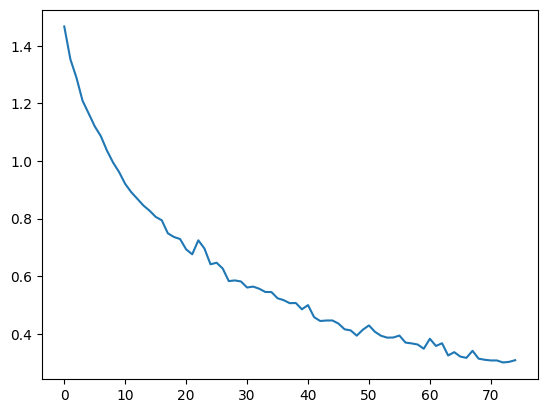

In [29]:
plt.plot([i for i in range(len(model.history.history['loss']))], model.history.history['loss'])

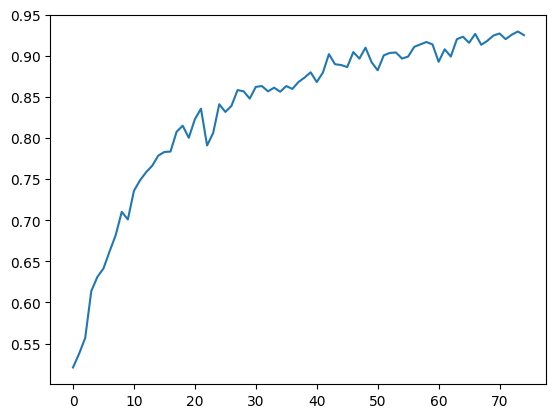

In [30]:
plt.plot([i for i in range(len(model.history.history['accuracy']))], model.history.history['accuracy'])

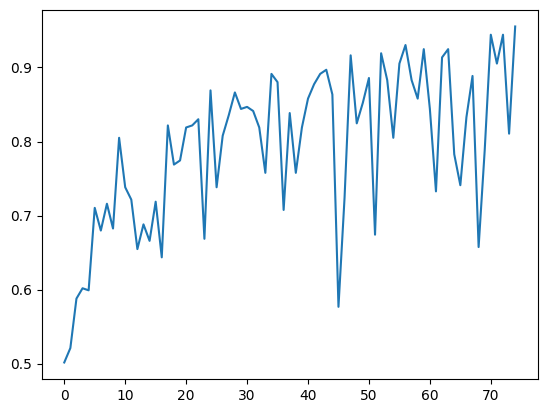

In [31]:
plt.plot([i for i in range(len(model.history.history['accuracy']))], model.history.history['val_accuracy'])

In [32]:
flipTest = glob.glob(testFolder + '/flip/*.jpg')
notFlipTest = glob.glob(testFolder + '/notflip/*.jpg')

testData = []
for picture in flipTest:
    img = Image.open(picture)
    testData.append([picture, 1, image.format, image.mode, image.size])
for picture in notFlipTest:
    img = Image.open(picture)
    testData.append([picture, 0, image.format, image.mode, image.size])
    
testDF = pd.DataFrame(testData, columns=['path', 'label', 'format', 'mode', 'size'])
testDF = testDF.reset_index(drop=True)

# Evaluate the model
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)
testGenerator = test_datagen.flow_from_dataframe(directory=None, class_mode='raw', batch_size=64, y_col='label', x_col='path', dataframe=testDF)
loss, accuracy, precision, recall = model.evaluate_generator(testGenerator, verbose=1)
print('Test accuracy:', accuracy)

Found 597 validated image filenames.


/tmp/ipykernel_3754/1091528003.py:18: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy, precision, recall = model.evaluate_generator(testGenerator, verbose=1)


10/10 [==============================] - 5s 447ms/step - loss: 0.2708 - accuracy: 0.9347 - precision: 0.9088 - recall: 0.9621
Test accuracy: 0.9346733689308167


In [33]:
f1 = 2 * (precision * recall) / (precision + recall)
f1

0.9346733567150157

In [35]:
sys.path.append('/home/jmelvin/miniconda3/envs/tf/lib/python3.10/site-packages')

from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam

# Set the batch size and number of training steps per epoch
batchSize = 32

#the total number of images we have:
trainSize = len(trainDF)
trainSteps = np.ceil(trainSize/batchSize)

#same for the validation set
validSize = len(validDF)
validSteps = np.ceil(validSize/batchSize)

# Set the number of epochs for training
numEpochs = 75

# Load the pre-trained ResNet50 model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(1080, 1920, 3))

# Set all layers in the base model to not be trained
for layer in base_model.layers:
    layer.trainable = False
    
# Allow the last 5 layers of the base model to be trained
# From Kaggle reference
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Add new layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
#x = Flatten()(base_model.output)
x = Dense(1024, activation='relu', kernel_regularizer=l2(5e-4))(x)
#x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
#doing binary prediction, so just 1 neuron is enough
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

# Define the data generators
train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)
trainGenerator = train_datagen.flow_from_dataframe(directory=None, shuffle=True, class_mode='raw', batch_size=batchSize, y_col='label', x_col='path', dataframe=trainDF)
valid_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)
validGenerator = valid_datagen.flow_from_dataframe(directory=None, shuffle=True, class_mode='raw', batch_size=batchSize, y_col='label', x_col='path', dataframe=validDF)

# Train the model
model.fit_generator(trainGenerator, steps_per_epoch=trainSteps, epochs=numEpochs, validation_data=validGenerator, validation_steps=validSteps, verbose=1)



17225924/17225924 [==============================] - 1s 0us/step
Found 2033 validated image filenames.
Found 359 validated image filenames.


/tmp/ipykernel_3754/1502912661.py:59: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(trainGenerator, steps_per_epoch=trainSteps, epochs=numEpochs, validation_data=validGenerator, validation_steps=validSteps, verbose=1)


Epoch 1/75
 1/64 [..............................] - ETA: 3:48 - loss: 1.3676 - accuracy: 0.6250 - precision: 0.5909 - recall: 0.8125

2023-04-30 20:33:56.432501: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-30 20:33:56.443228: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-30 20:33:56.556506: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-30 20:33:56.556576: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

19/64 [=======>......................] - ETA: 16s - loss: 1.3593 - accuracy: 0.4789 - precision: 0.4571 - recall: 0.4491

2023-04-30 20:34:03.082651: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-30 20:34:03.082757: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-30 20:34:03.109713: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-30 20:34:03.109776: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

64/64 [==============================] - 29s 396ms/step - loss: 1.2772 - accuracy: 0.5445 - precision: 0.5298 - recall: 0.5158 - val_loss: 1.2342 - val_accuracy: 0.5014 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75


2023-04-30 20:34:21.535695: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-30 20:34:21.537390: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


64/64 [==============================] - 22s 339ms/step - loss: 1.1886 - accuracy: 0.6016 - precision: 0.5864 - recall: 0.5972 - val_loss: 1.1805 - val_accuracy: 0.5070 - val_precision: 1.0000 - val_recall: 0.0112
Epoch 3/75
64/64 [==============================] - 21s 321ms/step - loss: 1.1368 - accuracy: 0.6409 - precision: 0.6365 - recall: 0.6002 - val_loss: 1.1538 - val_accuracy: 0.6741 - val_precision: 0.7818 - val_recall: 0.4804
Epoch 4/75
64/64 [==============================] - 21s 335ms/step - loss: 1.0795 - accuracy: 0.6763 - precision: 0.6727 - recall: 0.6439 - val_loss: 1.1764 - val_accuracy: 0.5125 - val_precision: 1.0000 - val_recall: 0.0223
Epoch 5/75
64/64 [==============================] - 21s 320ms/step - loss: 1.0348 - accuracy: 0.7113 - precision: 0.7102 - recall: 0.6806 - val_loss: 1.1042 - val_accuracy: 0.6128 - val_precision: 0.8846 - val_recall: 0.2570
Epoch 6/75
64/64 [==============================] - 23s 358ms/step - loss: 1.0241 - accuracy: 0.7186 - precisio

64/64 [==============================] - 21s 322ms/step - loss: 0.4479 - accuracy: 0.9523 - precision: 0.9530 - recall: 0.9481 - val_loss: 2.1968 - val_accuracy: 0.5292 - val_precision: 1.0000 - val_recall: 0.0559
Epoch 39/75
64/64 [==============================] - 23s 357ms/step - loss: 0.4625 - accuracy: 0.9405 - precision: 0.9380 - recall: 0.9390 - val_loss: 0.5036 - val_accuracy: 0.9276 - val_precision: 0.9227 - val_recall: 0.9330
Epoch 40/75
64/64 [==============================] - 21s 332ms/step - loss: 0.4323 - accuracy: 0.9538 - precision: 0.9578 - recall: 0.9461 - val_loss: 0.6982 - val_accuracy: 0.8134 - val_precision: 0.7295 - val_recall: 0.9944
Epoch 41/75
64/64 [==============================] - 22s 338ms/step - loss: 0.4307 - accuracy: 0.9567 - precision: 0.9534 - recall: 0.9573 - val_loss: 1.7982 - val_accuracy: 0.5348 - val_precision: 0.5173 - val_recall: 1.0000
Epoch 42/75
64/64 [==============================] - 20s 316ms/step - loss: 0.4339 - accuracy: 0.9493 - prec

64/64 [==============================] - 21s 332ms/step - loss: 0.2817 - accuracy: 0.9651 - precision: 0.9691 - recall: 0.9583 - val_loss: 3.0669 - val_accuracy: 0.5125 - val_precision: 0.5056 - val_recall: 1.0000
Epoch 75/75
64/64 [==============================] - 21s 322ms/step - loss: 0.2717 - accuracy: 0.9700 - precision: 0.9675 - recall: 0.9705 - val_loss: 2.1342 - val_accuracy: 0.5571 - val_precision: 0.5296 - val_recall: 1.0000


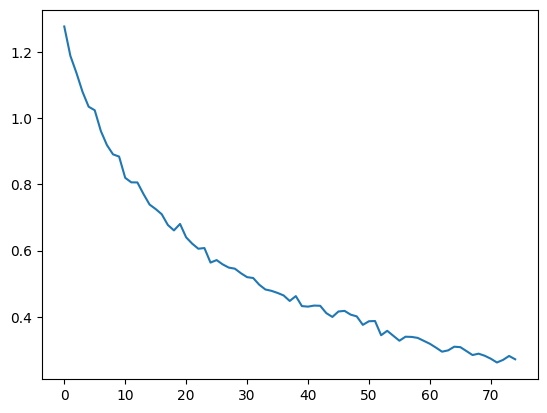

In [36]:
plt.plot([i for i in range(len(model.history.history['loss']))], model.history.history['loss'])

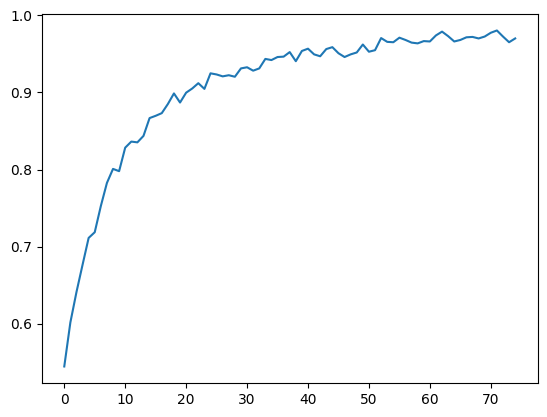

In [37]:
plt.plot([i for i in range(len(model.history.history['accuracy']))], model.history.history['accuracy'])

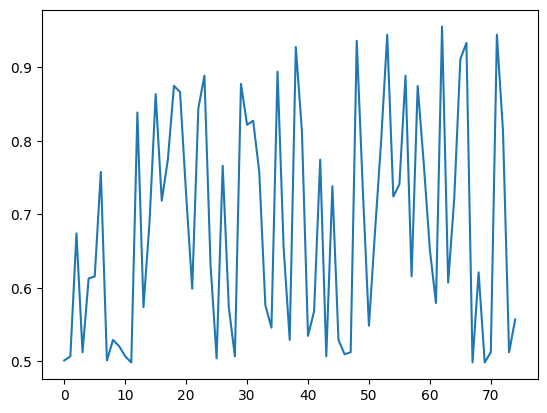

In [38]:
plt.plot([i for i in range(len(model.history.history['accuracy']))], model.history.history['val_accuracy'])

In [41]:
flipTest = glob.glob(testFolder + '/flip/*.jpg')
notFlipTest = glob.glob(testFolder + '/notflip/*.jpg')

testData = []
for picture in flipTest:
    img = Image.open(picture)
    testData.append([picture, 1, image.format, image.mode, image.size])
for picture in notFlipTest:
    img = Image.open(picture)
    testData.append([picture, 0, image.format, image.mode, image.size])
    
testDF = pd.DataFrame(testData, columns=['path', 'label', 'format', 'mode', 'size'])
testDF = testDF.reset_index(drop=True)

# Evaluate the model
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)
testGenerator = test_datagen.flow_from_dataframe(directory=None, class_mode='raw', batch_size=32, y_col='label', x_col='path', dataframe=testDF)
loss, accuracy, precision, recall = model.evaluate_generator(testGenerator, verbose=1)
print('Test accuracy:', accuracy)

Found 597 validated image filenames.


/tmp/ipykernel_3754/3900198248.py:18: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy, precision, recall = model.evaluate_generator(testGenerator, verbose=1)


19/19 [==============================] - 7s 341ms/step - loss: 2.3053 - accuracy: 0.5209 - precision: 0.5035 - recall: 1.0000
Test accuracy: 0.5209380388259888


In [40]:
f1 = 2 * (precision * recall) / (precision + recall)
f1

0.6697459467101236


### -- Getting good performance with both MobileNet and ResNet50 

### -- Need to do some hyperarameter tuning, looks like a LearningRateSchedule would probably help

### -- Validation metrics/loss are very noisy, is it correct that the validation data is only from 1 batch and not the whole validation set?  If so, is that the best way to do it, or should I run my entire validation set each Epoch?

### -- Why do I need a pooling layer?

In [52]:
base_model.output

<KerasTensor: shape=(None, 33, 60, 1024) dtype=float32 (created by layer 'conv_pw_13_relu')>

In [56]:
base_model.layers[-6:]

In [57]:
dir(base_model.layers[-1])

['_TF_MODULE_IGNORED_PROPERTIES',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_auto_config',
 '_auto_get_config',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_build_input_shape',
 '_call_spec',
 '_callable_losses',
 '_captured_weight_regularizer',
 '_cast_single_input',
 '_checkpoint_dependencies',
 '_clear_losses',
 '_compute_dtype',
 '_compute_dtype_object',
 '_dedup_weights',
 '_deferred_dependencies',
 '_delete_tracking',
 '_deserialization_dependencies',
 '_deserializ

In [85]:
for layer in base_model.layers:
    print (layer.name, layer.input_shape, layer.output_shape)

input_8 [(None, 1080, 1920, 3)] [(None, 1080, 1920, 3)]
conv1 (None, 1080, 1920, 3) (None, 540, 960, 32)
conv1_bn (None, 540, 960, 32) (None, 540, 960, 32)
conv1_relu (None, 540, 960, 32) (None, 540, 960, 32)
conv_dw_1 (None, 540, 960, 32) (None, 540, 960, 32)
conv_dw_1_bn (None, 540, 960, 32) (None, 540, 960, 32)
conv_dw_1_relu (None, 540, 960, 32) (None, 540, 960, 32)
conv_pw_1 (None, 540, 960, 32) (None, 540, 960, 64)
conv_pw_1_bn (None, 540, 960, 64) (None, 540, 960, 64)
conv_pw_1_relu (None, 540, 960, 64) (None, 540, 960, 64)
conv_pad_2 (None, 540, 960, 64) (None, 541, 961, 64)
conv_dw_2 (None, 541, 961, 64) (None, 270, 480, 64)
conv_dw_2_bn (None, 270, 480, 64) (None, 270, 480, 64)
conv_dw_2_relu (None, 270, 480, 64) (None, 270, 480, 64)
conv_pw_2 (None, 270, 480, 64) (None, 270, 480, 128)
conv_pw_2_bn (None, 270, 480, 128) (None, 270, 480, 128)
conv_pw_2_relu (None, 270, 480, 128) (None, 270, 480, 128)
conv_dw_3 (None, 270, 480, 128) (None, 270, 480, 128)
conv_dw_3_bn (None, 270

In [91]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
#x = Flatten()(base_model.output)
x = Dense(1024, activation='relu', kernel_regularizer=l2(5e-4))(x)
#x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
#doing binary prediction, so just 1 neuron is enough
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

In [92]:
for layer in model.layers[-10:]:
    print (layer.name, layer.input_shape, layer.output_shape)

conv_dw_13_bn (None, 33, 60, 1024) (None, 33, 60, 1024)
conv_dw_13_relu (None, 33, 60, 1024) (None, 33, 60, 1024)
conv_pw_13 (None, 33, 60, 1024) (None, 33, 60, 1024)
conv_pw_13_bn (None, 33, 60, 1024) (None, 33, 60, 1024)
conv_pw_13_relu (None, 33, 60, 1024) (None, 33, 60, 1024)
global_average_pooling2d_11 (None, 33, 60, 1024) (None, 1024)
dropout_18 (None, 1024) (None, 1024)
dense_19 (None, 1024) (None, 1024)
dropout_19 (None, 1024) (None, 1024)
dense_20 (None, 1024) (None, 1)


In [ ]:
for layer in model.layers[-10:]:
    print (layer.name, layer.input_shape, layer.output_shape)

In [93]:
sys.path.append('/home/jmelvin/miniconda3/envs/tf/lib/python3.10/site-packages')

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam

# Set the batch size and number of training steps per epoch
batchSize = 32

#the total number of images we have:
trainSize = len(trainDF)
trainSteps = np.ceil(trainSize/batchSize)

#same for the validation set
validSize = len(validDF)
validSteps = np.ceil(validSize/batchSize)

# Set the number of epochs for training
numEpochs = 50

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(1080, 1920, 3))

# Set all layers in the base model to not be trained
for layer in base_model.layers:
    layer.trainable = False
    
# Allow the last 5 layers of the base model to be trained
# From Kaggle reference
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Add new layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
#x = Flatten()(base_model.output)
x = Dense(1024, activation='relu', kernel_regularizer=l2(5e-4))(x)
#x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
#doing binary prediction, so just 1 neuron is enough
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model_res_1e3 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_res_1e3.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

# Define the data generators
train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)
trainGenerator = train_datagen.flow_from_dataframe(directory=None, shuffle=True, class_mode='raw', batch_size=batchSize, y_col='label', x_col='path', dataframe=trainDF)
valid_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)
validGenerator = valid_datagen.flow_from_dataframe(directory=None, shuffle=True, class_mode='raw', batch_size=batchSize, y_col='label', x_col='path', dataframe=validDF)

# Train the model
model_res_1e3.fit_generator(trainGenerator, steps_per_epoch=trainSteps, epochs=numEpochs, validation_data=validGenerator, validation_steps=validSteps, verbose=1)

Found 2033 validated image filenames.
Found 359 validated image filenames.


/tmp/ipykernel_3754/1266633039.py:59: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_res_1e3.fit_generator(trainGenerator, steps_per_epoch=trainSteps, epochs=numEpochs, validation_data=validGenerator, validation_steps=validSteps, verbose=1)


Epoch 1/50
64/64 [==============================] - 32s 406ms/step - loss: 1.3662 - accuracy: 0.5160 - precision: 0.4995 - recall: 0.4832 - val_loss: 1.9833 - val_accuracy: 0.4986 - val_precision: 0.4986 - val_recall: 1.0000
Epoch 2/50
64/64 [==============================] - 24s 374ms/step - loss: 1.0521 - accuracy: 0.5460 - precision: 0.5314 - recall: 0.5168 - val_loss: 1.2762 - val_accuracy: 0.4986 - val_precision: 0.4986 - val_recall: 1.0000
Epoch 3/50
64/64 [==============================] - 23s 355ms/step - loss: 0.8891 - accuracy: 0.6203 - precision: 0.6187 - recall: 0.5595 - val_loss: 1.0459 - val_accuracy: 0.4986 - val_precision: 0.4986 - val_recall: 1.0000
Epoch 4/50
64/64 [==============================] - 22s 350ms/step - loss: 0.8355 - accuracy: 0.6158 - precision: 0.6150 - recall: 0.5493 - val_loss: 0.9187 - val_accuracy: 0.4986 - val_precision: 0.4986 - val_recall: 1.0000
Epoch 5/50
64/64 [==============================] - 23s 352ms/step - loss: 0.7777 - accuracy: 0.6385

64/64 [==============================] - 19s 303ms/step - loss: 0.4763 - accuracy: 0.7885 - precision: 0.7976 - recall: 0.7538 - val_loss: 1.1715 - val_accuracy: 0.5404 - val_precision: 1.0000 - val_recall: 0.0782
Epoch 38/50
64/64 [==============================] - 20s 308ms/step - loss: 0.4723 - accuracy: 0.8023 - precision: 0.8029 - recall: 0.7833 - val_loss: 0.9353 - val_accuracy: 0.5627 - val_precision: 1.0000 - val_recall: 0.1229
Epoch 39/50
64/64 [==============================] - 20s 317ms/step - loss: 0.4752 - accuracy: 0.8003 - precision: 0.8119 - recall: 0.7640 - val_loss: 1.4935 - val_accuracy: 0.5376 - val_precision: 1.0000 - val_recall: 0.0726
Epoch 40/50
64/64 [==============================] - 20s 307ms/step - loss: 0.4812 - accuracy: 0.7993 - precision: 0.7979 - recall: 0.7833 - val_loss: 0.4161 - val_accuracy: 0.8245 - val_precision: 0.7900 - val_recall: 0.8827
Epoch 41/50
64/64 [==============================] - 20s 316ms/step - loss: 0.4231 - accuracy: 0.8229 - prec

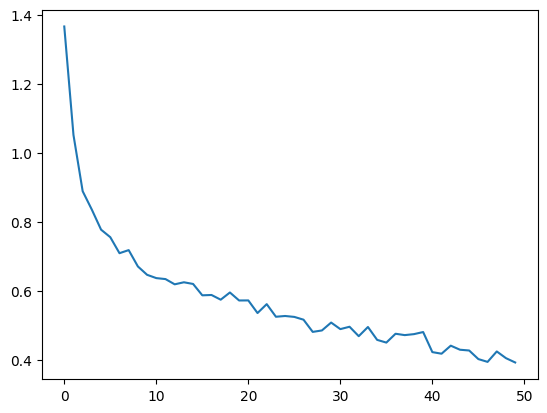

In [94]:
plt.plot([i for i in range(len(model_res_1e3.history.history['loss']))], model_res_1e3.history.history['loss'])

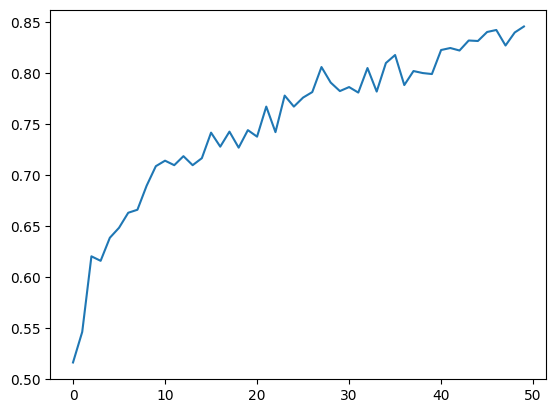

In [95]:
plt.plot([i for i in range(len(model_res_1e3.history.history['accuracy']))], model_res_1e3.history.history['accuracy'])

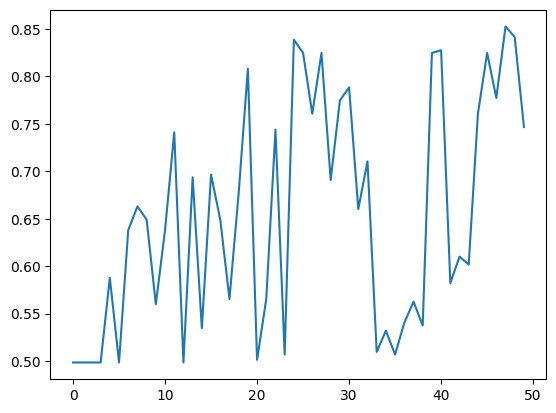

In [96]:
plt.plot([i for i in range(len(model_res_1e3.history.history['val_accuracy']))], model_res_1e3.history.history['val_accuracy'])